In [ ]:
import sys
print(sys.executable)

In [ ]:
import quandl
import pandas_datareader as pdr

import pandas as pd
import yfinance as yf
import numpy as np

from datetime import date

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import copy

In [ ]:
from tqdm import tqdm

In [ ]:
# Detailed info on each indicator check on web: https://fred.stlouisfed.org/series/<indicator_name>
# DOC with the metrics and external exploratory Colab: https://docs.google.com/document/d/1Cf4C3Xz4_yitlzPaLEknHoDlw7KMXey4c49kZ7ucQEE/edit?usp=sharing

FRED_INDICATORS = ['GDP', 'GDPC1', 'GDPPOT', 'NYGDPMKTPCDWLD',         # 1. Growth
                   'CPIAUCSL', 'CPILFESL', 'GDPDEF',                   # 2. Prices and Inflation
                   'M1SL', 'WM1NS', 'WM2NS', 'M1V', 'M2V', 'WALCL',    # 3. Money Supply
                   'DFF', 'DTB3', 'DGS5', 'DGS10', 'DGS30', 'T5YIE',   # 4. Interest Rates
                   'T10YIE', 'T5YIFR', 'TEDRATE', 'DPRIME',            # 4. Interest Rates
                   'UNRATE', 'NROU', 'CIVPART', 'EMRATIO',             # 5. Employment
                   'UNEMPLOY', 'PAYEMS', 'MANEMP', 'ICSA', 'IC4WSA',   # 5. Employment
                   'CDSP', 'MDSP', 'FODSP', 'DSPIC96', 'PCE', 'PCEDG', # 6. Income and Expenditure
                   'PSAVERT', 'DSPI', 'RSXFS',                         # 6. Income and Expenditure
                   'INDPRO', 'TCU', 'HOUST', 'GPDI', 'CP', 'STLFSI2',  # 7. Other indicators
                   'DCOILWTICO', 'DTWEXAFEGS', 'DTWEXBGS',             # 7. Other indicators
                   'GFDEBTN', 'GFDEGDQ188S',                           # 8. Gov-t debt
                   # 9. Additional indicators from IVAN
                   'DEXUSEU', 'GVZCLS', 'VIXCLS', 'DIVIDEND',
                   # 9. Additional indicators from IVAN
                   'MORTGAGE30US', 'SPCS20RSA'
                   ]

# Macro Indicators from QUANDL
QUANDL_INDICATORS = {'BCHAIN/MKPRU', 'USTREASURY/YIELD', 'USTREASURY/REALYIELD',  # 9. Additional indicators from IVAN
                     # 9. Additional indicators from IVAN
                     'MULTPL/SHILLER_PE_RATIO_MONTH', 'LBMA/GOLD'
                     }

# Stock maret indexes
  # All indexes: https://stooq.com/t/ 
STOOQ_INDICATORS = {'^DJI','^SPX'}  

# update period for each ind (Y=Yearly, Q=Quarterly, M=Monthly, W=Weekly, D=Daily)
INDICATORS_PERIODS = {'GDP': 'Q', 'GDPC1': 'Q', 'GDPPOT': 'Q', 'NYGDPMKTPCDWLD': 'Y',                 # 1. Growth
                      # 2. Prices and Inflation
                      'CPIAUCSL': 'M', 'CPILFESL': 'M', 'GDPDEF': 'Q',
                      # 3. Money Supply
                      'M1SL': 'M', 'WM1NS': 'W', 'WM2NS': 'W', 'M1V': 'Q', 'M2V': 'Q', 'WALCL': 'W',
                      # 4. Interest Rates
                      'DFF': 'D', 'DTB3': 'D', 'DGS5': 'D', 'DGS10': 'D', 'DGS30': 'D', 'T5YIE': 'D',
                      # 4. Interest Rates
                      'T10YIE': 'D', 'T5YIFR': 'D', 'TEDRATE': 'D', 'DPRIME': 'D',
                      # 5. Employment
                      'UNRATE': 'M', 'NROU': 'Q', 'CIVPART': 'M', 'EMRATIO': 'M',
                      # 5. Employment
                      'UNEMPLOY': 'M', 'PAYEMS': 'M', 'MANEMP': 'M', 'ICSA': 'W', 'IC4WSA': 'W',
                      # 6. Income and Expenditure
                      'CDSP': 'Q', 'MDSP': 'Q', 'FODSP': 'Q', 'DSPIC96': 'M', 'PCE': 'M', 'PCEDG': 'M',
                      # 6. Income and Expenditure
                      'PSAVERT': 'M', 'DSPI': 'M', 'RSXFS': 'M',
                      # 7. Other indicators
                      'INDPRO': 'M', 'TCU': 'M', 'HOUST': 'M', 'GPDI': 'Q', 'CP': 'Q', 'STLFSI2': 'W',
                      # 7. Other indicators
                      'DCOILWTICO': 'D', 'DTWEXAFEGS': 'D', 'DTWEXBGS': 'D',
                      # 8. Gov-t debt
                      'GFDEBTN': 'Q', 'GFDEGDQ188S': 'Q',
                      # 9. FRED: Additional indicators from IVAN
                      'DEXUSEU': 'D', 'GVZCLS': 'D', 'VIXCLS': 'D', 'DIVIDEND': 'Q',
                      # 9. FRED: Additional indicators from IVAN
                      'MORTGAGE30US': 'W', 'SPCS20RSA': 'M',
                      # 9.QUANDL: Additional indicators from IVAN
                      'BCHAIN_MKPRU': 'D', 'USTREASURY_YIELD': 'D', 'USTREASURY_REALYIELD': 'D',
                      'MULTPL_SHILLER_PE_RATIO_MONTH': 'M', 'LBMA_GOLD': 'D',
                      # 10. INDEXES
                      'SPX': 'D', 'DJI': 'D'
                      }

In [ ]:
end = date.today()
start = date(year=end.year-35, month=end.month, day=end.day)
macro_indicators = dict()
tq_fred = tqdm(FRED_INDICATORS)

# get the stats from FRED database (with Pandas Datareader API)
tq_fred.set_description('Downloading stats from FRED:')
for indicator in tq_fred:
  # tq_fred.set_description(indicator)
  # macro_indicators[indicator] = pdr.DataReader(indicator, "fred", start=start, timeout=90)
  macro_indicators[indicator] = pdr.fred.FredReader(indicator, start=start, timeout=90).read()

In [ ]:
macro_indicators['GDP']

In [ ]:
tq_quandl = tqdm(QUANDL_INDICATORS)
# get the stats from QUANDL database
tq_quandl.set_description("Downloading stats from QUANDL:")
for indicator in tq_quandl:
 # tq_quandl.set_description(indicator)
 # modify all indicator names '/': like "USTREASURY/YIELD" to "USTREASURY_YIELD"
 macro_indicators[indicator.replace("/", "_")] = quandl.get(indicator, start_date=start, end_date=end, authtoken="5qE7KbLemDiZ9RfNsVuM")

In [ ]:
for indicator in tqdm(STOOQ_INDICATORS):
  macro_indicators[indicator.replace("^", "")]= pdr.get_data_stooq(indicator, start, end)

In [ ]:
for i,value in enumerate(macro_indicators.keys()):
  if i%6==0:
    print('\n')
  print(value, end =", ")  

In [ ]:
macro_indicators['GDP']

In [ ]:
# ORIGINAL STATS (need to reverse SPX and DJI):

macro_indicators['SPX'].tail()

In [ ]:
macro_indicators['SPX'] = macro_indicators['SPX'].reindex(index=macro_indicators['SPX'].index[::-1])
macro_indicators['DJI'] = macro_indicators['DJI'].reindex(index=macro_indicators['DJI'].index[::-1])

In [ ]:
macro_indicators['SPX'].tail()

In [ ]:
macro_indicators['SPX']['Close'].plot.line(figsize=(20,6), grid = True, title='S&P500 Stock index')

In [ ]:
macro_indicators['DJI']['Close'].plot.line(figsize=(20,6), grid = True, title='DJI Stock index')

In [ ]:
# https://fred.stlouisfed.org/series/GVZCLS
macro_indicators['GVZCLS'].plot.line(figsize=(20,6), grid = True, title='CBOE Gold ETF Volatility Index (GVZCLS) - daily')

In [ ]:
# https://fred.stlouisfed.org/series/VIXCLS
macro_indicators['VIXCLS'].plot.line(figsize=(20,6), grid = True, title=' CBOE Volatility Index: VIX (VIXCLS)	 - daily')

In [ ]:
# https://fred.stlouisfed.org/series/STLFSI2
macro_indicators['STLFSI2'].plot.line(figsize=(20,6), grid = True, title='St. Louis Fed Financial Stress Index (STLFSI2) - daily')

In [ ]:
# https://fred.stlouisfed.org/series/FODSP
macro_indicators['FODSP'].plot.line(figsize=(20,6), grid = True, title=' Household Financial Obligations as a Percent of Disposable Personal Income (FODSP) - Quarterly')

In [ ]:
# https://www.multpl.com/shiller-pe
# https://data.nasdaq.com/data/MULTPL/SHILLER_PE_RATIO_MONTH-shiller-pe-ratio-by-month
macro_indicators['MULTPL_SHILLER_PE_RATIO_MONTH'].plot.line(figsize=(20,6), grid = True, title='Shiller PE Ratio - Monthly')

In [ ]:
# https://fred.stlouisfed.org/series/MANEMP
macro_indicators['MANEMP'].plot.line(figsize=(20,6), grid = True, title='All Employees, Manufacturing (MANEMP) - Monthly')

In [ ]:
macro_indicators.keys()

In [ ]:
# Total indicators from FRED, QUANDL, and STOOQ:
len(macro_indicators.keys())

In [ ]:
# need to have a deep copy of macro indicators to make local transformations not changing the datarepo
macro_indicators_dict = copy.deepcopy(macro_indicators)

In [ ]:
def get_macro_shift_transformation(macro_indicators_dict):
        """Add shifted (growth) values to the data_repo.macro_indicators before joining them together, remove non-stationary time series"""
        
        # Transform daily stats on this shift
        HISTORICAL_PERIODS_DAYS = [1, 3, 7, 30, 90, 365]
        
        # Different types of transformations for daily, weekly, monthly, indicators
        DoD_ind = [k for (k, v) in INDICATORS_PERIODS.items() if v == 'D']
        WoW_ind = [k for (k, v) in INDICATORS_PERIODS.items() if v == 'W']
        MoM_ind = [k for (k, v) in INDICATORS_PERIODS.items() if v == 'M']
        QoQ_ind = [k for (k, v) in INDICATORS_PERIODS.items() if v == 'Q']
        YoY_ind = [k for (k, v) in INDICATORS_PERIODS.items() if v == 'Y']

        # rename and drop some columns (especially from QUANDL)
        macro_indicators_dict['BCHAIN_MKPRU'].rename(
            columns={'Value': 'BCHAIN_MKPRU'}, inplace=True)
        macro_indicators_dict['MULTPL_SHILLER_PE_RATIO_MONTH'].rename(
            columns={'Value': 'MULTPL_SHILLER_PE_RATIO_MONTH'}, inplace=True)
        #  GOLD PRICE == evening (PM) value in USD on London Stock Exchange, drop all other columns
        macro_indicators_dict['LBMA_GOLD'].rename(
            columns={'USD (PM)': 'LBMA_GOLD'}, inplace=True)
        macro_indicators_dict['LBMA_GOLD'].drop(
            ['USD (AM)', 'GBP (AM)', 'GBP (PM)', 'EURO (AM)', 'EURO (PM)'], axis=1, inplace=True)
        
        # INDEXES: leave only Close price
        macro_indicators_dict['SPX'].drop(
            ['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)
        macro_indicators_dict['SPX'].rename(
            columns={'Close': 'SPX'}, inplace=True)
        macro_indicators_dict['DJI'].drop(
            ['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)
        macro_indicators_dict['DJI'].rename(
            columns={'Close': 'DJI'}, inplace=True)

        for ind in DoD_ind:
            # do transform only if oil_prices, blockchain_prices, gold_prices, indexes
            if not ind in {'DCOILWTICO', 'BCHAIN_MKPRU', 'LBMA_GOLD','SPX','DJI'}:
                continue
            # treat those as an index
            for i in HISTORICAL_PERIODS_DAYS:
                df = macro_indicators_dict[ind]
                ind_transformed = ind + '_growth_' + str(i)+'d'
                df[ind_transformed] = df[ind]/df[ind].shift(i)-1

        # future growth stats
        for ind in ['SPX','DJI']:
          for i in HISTORICAL_PERIODS_DAYS:
            df = macro_indicators_dict[ind]
            ind_transformed = ind + '_future_growth_' + str(i)+'d'
            df[ind_transformed] = df[ind].shift(-i-1)/df[ind].shift(-1)-1

        for ind in WoW_ind:
            df = macro_indicators_dict[ind]
            ind_transformed = ind + '_wow'
            df[ind_transformed] = df[ind]/df[ind].shift(1)-1
            ind_transformed = ind + '_mom'
            df[ind_transformed] = df[ind]/df[ind].shift(5)-1
            # drop original "ind" column if series are non-stationary
            # do not drop original ind for FinStressIndex (STLFSI2), and Long-term Mortgage rates
            if not ind in {'STLFSI2', 'MORTGAGE30US'}:
                macro_indicators_dict[ind].drop(
                    [ind], axis=1, inplace=True)

        for ind in MoM_ind:
            df = macro_indicators_dict[ind]
            ind_transformed = ind + '_mom'
            df[ind_transformed] = df[ind]/df[ind].shift(1)-1
            ind_transformed = ind + '_yoy'
            df[ind_transformed] = df[ind]/df[ind].shift(12)-1
            # drop original "ind" column if series are non-stationary
            # do not drop original ind for all indicators that are 'ratios' or 'percentages'
            if not ind in {'UNRATE', 'CIVPART', 'EMRATIO', 'PSAVERT', 'INDPRO', 'TCU', 'SPCS20RSA', 'MULTPL_SHILLER_PE_RATIO_MONTH'}:
                macro_indicators_dict[ind].drop(
                    [ind], axis=1, inplace=True)

        # create one field as div_ratio (% of profits paid as dividents)
        macro_indicators_dict['CP'] = macro_indicators_dict['CP'].join(
            macro_indicators_dict['DIVIDEND'])
        macro_indicators_dict['CP']['div_ratio'] = macro_indicators_dict['CP']['DIVIDEND'] / \
            macro_indicators_dict['CP']['CP']
        macro_indicators_dict['CP'].drop(
            ['DIVIDEND'], axis=1, inplace=True)

        for ind in QoQ_ind:
            df = macro_indicators_dict[ind]
            ind_transformed = ind + '_qoq'
            df[ind_transformed] = df[ind]/df[ind].shift(1)-1
            ind_transformed = ind + '_yoy'
            df[ind_transformed] = df[ind]/df[ind].shift(4)-1
            # drop original "ind" column if series are non-stationary
            # do not drop original ind for all indicators that are 'ratios' or 'percentages'
            if not ind in {'GDPDEF', 'M1V', 'M2V', 'NROU', 'CDSP', 'MDSP', 'FODSP', 'GFDEGDQ188S'}:
                macro_indicators_dict[ind].drop(
                    [ind], axis=1, inplace=True)

        for ind in YoY_ind:
            df = macro_indicators_dict[ind]
            ind_transformed = ind + '_yoy'
            df[ind_transformed] = df[ind]/df[ind].shift(1)-1
            macro_indicators_dict[ind].drop([ind], axis=1, inplace=True)

In [ ]:
get_macro_shift_transformation(macro_indicators_dict)

In [ ]:
# Daily
macro_indicators_dict['LBMA_GOLD'].tail(1)

In [ ]:
macro_indicators_dict['SPX'].tail(5)

In [ ]:
macro_indicators_dict['SPX']['SPX_growth_365d'].plot.line(figsize=(20,6), grid = True)

In [ ]:
macro_indicators_dict['DJI']['DJI_growth_365d'].plot.line(figsize=(20,6), grid = True)

In [ ]:
# Quarterly
macro_indicators_dict['GDP'].tail(5)

In [ ]:
# Monthly
macro_indicators_dict['CPILFESL'].tail(5)

In [ ]:
# Weekly
macro_indicators_dict['ICSA'].tail(5)

In [ ]:
# Yearly (WORLD GDP)
macro_indicators_dict['NYGDPMKTPCDWLD'].tail(1)

In [ ]:
for i,value in enumerate(macro_indicators_dict.keys()):
  if i%6==0:
    print('\n')
  print(value, end =", ")  

In [ ]:
dates = pd.DataFrame(macro_indicators_dict['SPX'].index.sort_values().unique(), columns=['Date'])
dates

In [ ]:
def get_daily_macro_stats_df(daily_df, macro_ind_df, regime='LAST'):
        """take Time from daily_df, and apply that to macro_ind_df, (LAST=take last observation, PREVIOUS=take previous) """
        ticker_dates = daily_df.Date.sort_values().unique()
        new_column_dict = {}

        for elem in ticker_dates:
            ts = pd.to_datetime(str(elem))
            d = ts.strftime('%Y-%m-%d')
            # all potential records to merge
            options_to_merge = macro_ind_df[macro_ind_df.index <= d]
            if len(options_to_merge) == 0:
                continue
            last_value = options_to_merge.tail(1).values.tolist()[0]
            prev_value = options_to_merge.tail(2).values.tolist()[0]
            if regime == 'PREVIOUS':
                if prev_value is not None:
                    new_column_dict[d] = prev_value
            elif regime == 'LAST':
                if last_value is not None:
                    new_column_dict[d] = last_value
            else:
                raise("Regime should be in ('PREVIOUS','LAST')")
        return pd.DataFrame.from_dict(new_column_dict, orient='index', columns = options_to_merge.keys())

In [ ]:
lastday_ind = [k for (k, v) in INDICATORS_PERIODS.items() if v not in ('M', 'Q', 'Y')]
  # join on the previous available date (M,Q,Y stats write say '2021-01-01' - but they represent the whole M,Q,Y STARTING at this date)
firstday_ind = [k for (k, v) in INDICATORS_PERIODS.items() if v in ('M', 'Q', 'Y')]

  # start from all dates we need to have macro stats
dates = pd.DataFrame(macro_indicators_dict['SPX'].index.sort_values().unique(), columns=['Date'])

macro_data_df = None
#  iterate over all transformed series in self.macro_indicators_dict and join one by one
# all non-Monthly indicators are
tq_last_day = tqdm(lastday_ind)
tq_last_day.set_description("Merging LAST Day indicators")
for ind in tq_last_day:
  # do not add some indicators to the final dataset (they are duplicated in another datasource)
  if ind in ('USTREASURY_YIELD', 'USTREASURY_REALYIELD'):
    continue
  df_to_merge = get_daily_macro_stats_df(dates, macro_indicators_dict[ind], regime='LAST')
  if macro_data_df is None:
    macro_data_df = df_to_merge
  else:
    macro_data_df = macro_data_df.join(df_to_merge)

tq_first_day = tqdm(firstday_ind)
tq_first_day.set_description("Merging FIRST Day indicators")
#  some stats  have first day of period date (e.g. '2020-06-01' instead of '2020-06-30'), so we need to get PREVIOUS available macro param
for ind in tq_first_day:
  df_to_merge = get_daily_macro_stats_df(dates, macro_indicators_dict[ind], regime='PREVIOUS')
  if macro_data_df is None:
    macro_data_df = df_to_merge
  else:
    macro_data_df = macro_data_df.join(df_to_merge)

In [ ]:
macro_data_df.info()

In [ ]:
# learn how to save a dataframe efficiently
macro_data_df.to_parquet('macro_df_small.parquet',compression='BROTLI')

In [ ]:
macro_df = pd.read_parquet('macro_df_small.parquet')

In [ ]:
len(macro_df.keys())

In [ ]:
i=1
for value in macro_df.keys():
  if not ('future' in value):
    print(value, end =", ")
    if i%8==0:
      print('\n')
    i+=1
    

In [ ]:
pd.set_option('display.max_columns', 10)
macro_df.tail(1)
# pd.set_option('display.max_columns', None)

In [ ]:
macro_df.tail(100)

In [ ]:
macro_indicators_dict['SPX']

In [ ]:
macro_df['SPX']

In [ ]:
macro_df.tail(1)

In [ ]:
macro_df.corr()

In [ ]:
SPX_growth_365d_corr = pd.DataFrame(macro_df.corr()['SPX_growth_365d'].sort_values())

In [ ]:
SPX_growth_365d_corr.head()

In [ ]:
SPX_growth_365d_corr.tail()

In [ ]:
filter = np.abs(SPX_growth_365d_corr.SPX_growth_365d)>=0.5
SPX_growth_365d_corr[filter].plot.barh(figsize=(20,10), grid=True)

In [ ]:
macro_df.corr()['SPX_growth_365d'].sort_values()

In [ ]:
macro_df.corr()['DJI_growth_365d'].sort_values()

In [ ]:
macro_df.corr()['SPX_growth_90d'].sort_values()

In [ ]:
macro_df.corr()['SPX_growth_30d'].sort_values()

In [ ]:
# Future growth indicators are mostly correlated with each other
future_ind = []
for ind in macro_df.keys():
  if 'future' in ind:
    future_ind.append(ind)
  
print(future_ind)

In [ ]:
# include all features 
macro_df_no_future_ind = macro_df.keys()
# do not use future_ind in the list to find correlations with the label (which is a future_indicator)
macro_df_no_future_ind = macro_df_no_future_ind.drop(future_ind)

In [ ]:
macro_df.corr()['SPX_future_growth_365d'][macro_df_no_future_ind].sort_values()

In [ ]:
macro_df.corr()['SPX_future_growth_90d'][macro_df_no_future_ind].sort_values()

In [ ]:
macro_df.corr()['SPX_future_growth_30d'][macro_df_no_future_ind].sort_values()

In [ ]:
# all features should be numeric
for key in macro_df.keys():
  macro_df[key] = macro_df[key].astype(float)

In [ ]:
# include all features 
X_keys = macro_df.keys()
# do not use future ind to predict
X_keys = X_keys.drop(future_ind)

In [ ]:
# deep copy of the dataframe not to change the original df
macro_copy = macro_df.copy(deep=True)

In [ ]:
# replace bad values with np.nan
macro_copy.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
macro_copy.fillna(0,inplace=True)
# macro_copy.dropna(inplace=True)

In [ ]:
macro_copy.shape

In [ ]:
X = macro_copy[X_keys]

In [ ]:
#get all features in X and dependent variable in y
y = macro_copy['SPX_future_growth_90d']

In [ ]:
X.tail()

In [ ]:
# https://machinelearningmastery.com/calculate-feature-importance-with-python/

from collections import OrderedDict
from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot

In [ ]:
# define a function that returns an ordered dictionary of features, sorted by importance
def get_importance_features(model):
  importance = model.feature_importances_
  feat_imp = OrderedDict()
  # summarize feature importance
  for i,v in enumerate(importance):
    feat_imp[X.keys()[i]] = importance[i]

  # https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value  
  sorted_feat_imp = sorted(feat_imp.items(), key=lambda kv: kv[1])

  return sorted_feat_imp

In [ ]:
# init the class and fit the model
decision_tree_model = DecisionTreeRegressor()
decision_tree_model.fit(X, y)

decision_feat_imp = get_importance_features(decision_tree_model)

In [ ]:
# Prediction of SPX_future_growth_90d:
decision_feat_imp[-10:]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
# define the model
decision_tree_model2 = DecisionTreeRegressor()
decision_tree_model2.fit(X_train, y_train)

decision_feat_imp2 = get_importance_features(decision_tree_model2)

In [ ]:
decision_feat_imp2[-10:]

In [ ]:
y_pred = decision_tree_model2.predict(X_test)

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted':y_pred})
df[0:10]

In [ ]:
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(max_depth=8, random_state=0)

In [ ]:
clf.fit(X_train, y_train)

clf_imp = get_importance_features(clf)

In [ ]:
y_pred_clf = clf.predict(X_test)

In [153]:
df2 = pd.DataFrame({'Actual': y_test, 'Predicted':y_pred_clf})


              Actual  Predicted
2016-12-23  0.057517   0.044895
2016-12-27  0.065336   0.044895
2016-12-28  0.066853   0.044895
2016-12-29  0.069505   0.044895
2016-12-30  0.058937   0.044895
...              ...        ...
2023-12-20  0.000000   0.032191
2023-12-21  0.000000   0.030034
2023-12-22  0.000000   0.029674
2023-12-26  0.000000   0.030034
2023-12-27  0.000000   0.030034

[1763 rows x 2 columns]


In [ ]:
# Decision Tree : Actual vs. Predicted graph
import matplotlib.ticker as mtick

ax = df.plot(figsize=(20,6), grid=True)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))


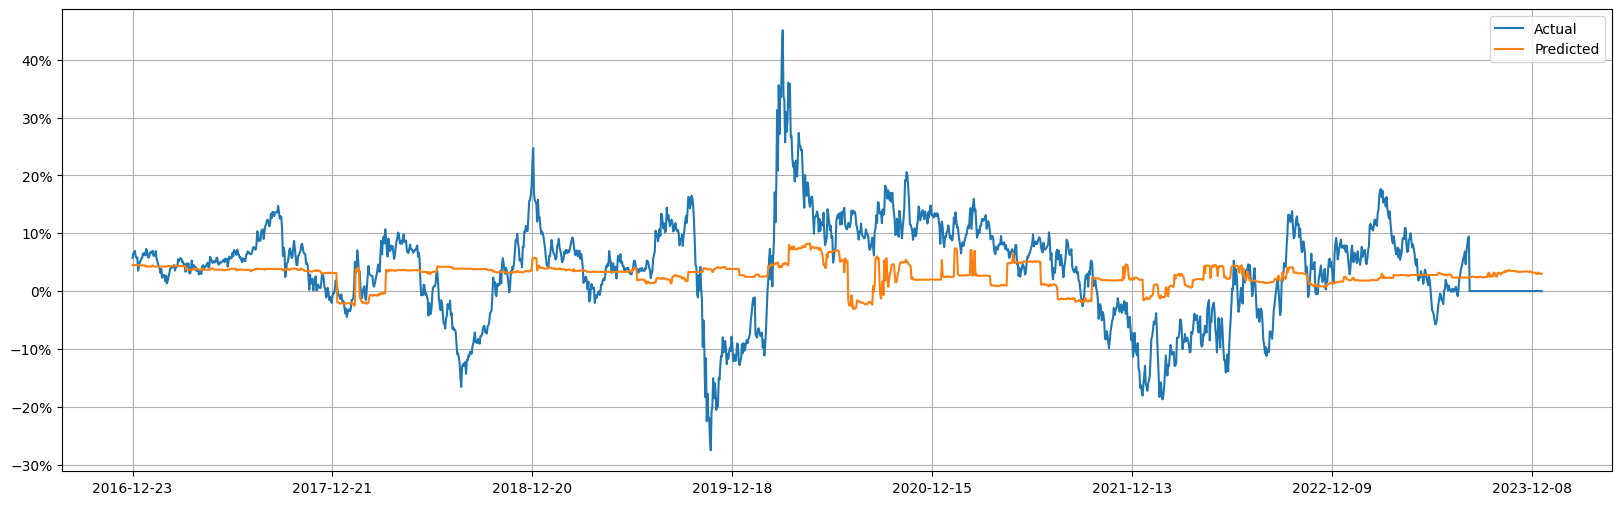

In [151]:
# Random Forest regressor : Actual vs. Predicted graph

import matplotlib.ticker as mtick

ax = df2.plot(figsize=(20,6), grid=True)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

In [ ]:
# what is the distribution of errors?
import seaborn as sns
sns.distplot(y_test-y_pred)

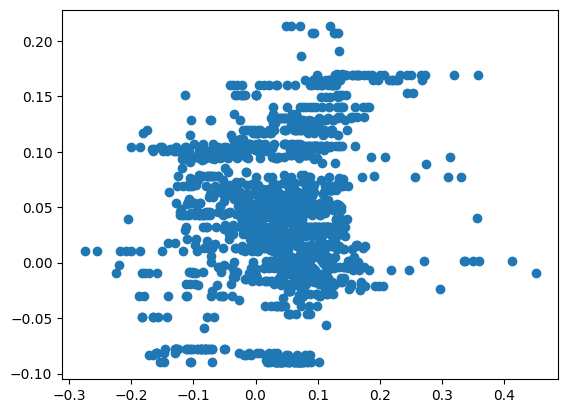

In [150]:
plt.scatter(y_test,y_pred)

In [ ]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [149]:
# GridSearch for Hyperparams: https://www.nbshare.io/notebook/312837011/Decision-Tree-Regression-With-Hyper-Parameter-Tuning-In-Python/
parameters={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }
# parameters={"splitter":["best","random"],
#             "max_depth" : [1,3,5,7],
#            "min_samples_leaf":[1,2,3,4],
#            "min_weight_fraction_leaf":[0.1,0.2,0.3],
#            "max_features":["auto","log2","sqrt",None],
#            "max_leaf_nodes":[None,10,20,30] }

In [148]:
from sklearn.model_selection import GridSearchCV

tuning_model = GridSearchCV(decision_tree_model, 
                            param_grid=parameters, 
                            scoring='neg_mean_squared_error',
                            cv=3,
                            verbose=3,
                            n_jobs = -1)
# https://stackoverflow.com/questions/18752795/gridsearchcv-n-jobs-in-parallel-internals

In [147]:

def timer(start_time=None):
    if not start_time:
        start_time=datetime.now()
        return start_time
    elif start_time:
        thour,temp_sec=divmod((datetime.now()-start_time).total_seconds(),3600)
        tmin,tsec=divmod(temp_sec,60)
        #print(thour,":",tmin,':',round(tsec,2))

In [ ]:
%%capture
from datetime import datetime

start_time=timer(None)

tuning_model.fit(X,y)

timer(start_time)

In [144]:
tuning_model.best_params_


{'max_depth': 3,
 'max_features': 'log2',
 'max_leaf_nodes': 40,
 'min_samples_leaf': 6,
 'min_weight_fraction_leaf': 0.1,
 'splitter': 'random'}

In [145]:
tuned_hyper_model= DecisionTreeRegressor(max_depth=12,
                                         max_features='sqrt',
                                         max_leaf_nodes=70,
                                         min_samples_leaf=1,
                                         min_weight_fraction_leaf=0.1,
                                         splitter='random')

In [ ]:
tuned_pred = tuned_hyper_model.predict(X_test)

In [157]:
df3 = pd.DataFrame({'Actual': y_test, 'Predicted':tuned_pred})
df3.to_excel('df3.xlsx')

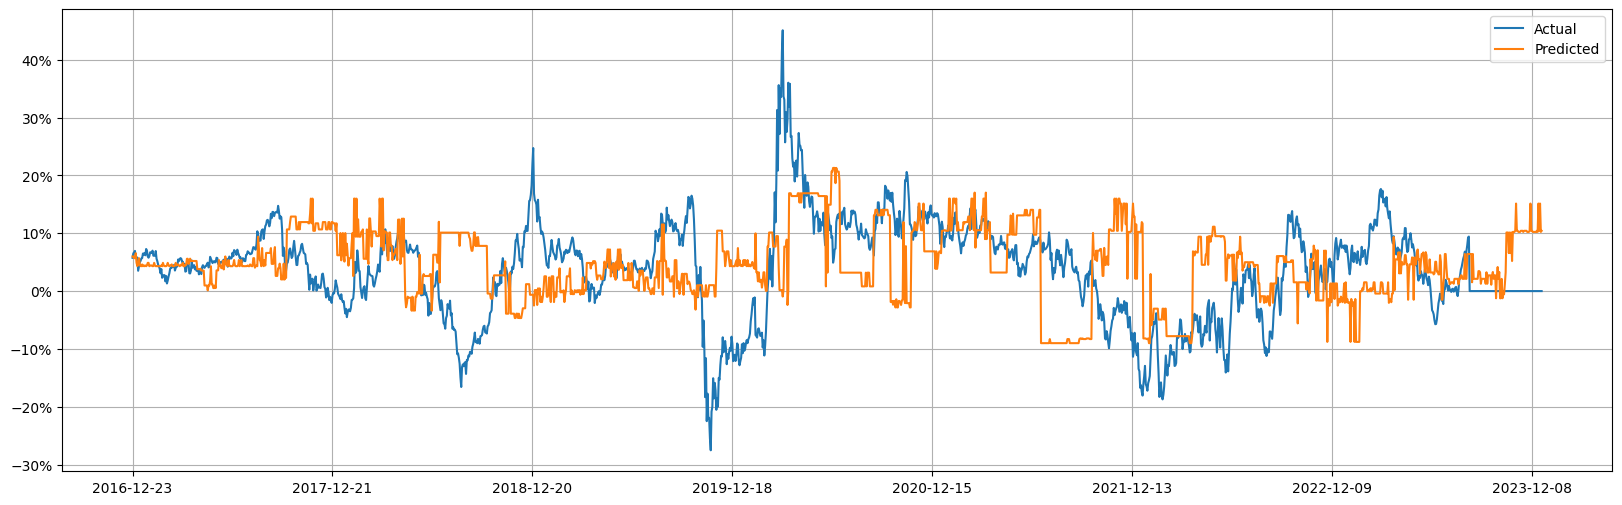

In [142]:
ax = df.plot(figsize=(20,6), grid=True)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))


              Actual  Predicted
2016-12-23  0.057517   0.015640
2016-12-27  0.065336   0.015640
2016-12-28  0.066853   0.032033
2016-12-29  0.069505   0.032033
2016-12-30  0.058937   0.015640
...              ...        ...
2023-12-20  0.000000   0.032033
2023-12-21  0.000000   0.032033
2023-12-22  0.000000   0.015640
2023-12-26  0.000000   0.015640
2023-12-27  0.000000   0.032033

[1763 rows x 2 columns]


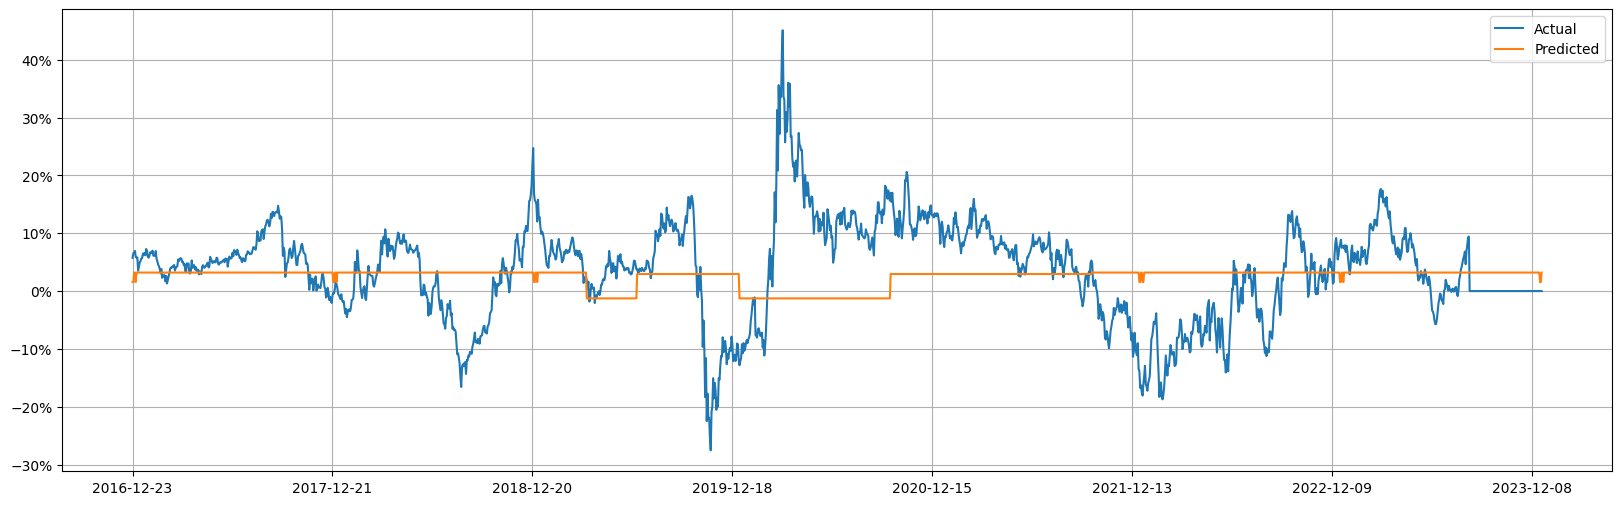

In [155]:
ax = df3.plot(figsize=(20,6), grid=True)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))